# 0. Importación de librerías y declaración de variables

In [1]:
from data.dataset import load_captions_csv, clean_caption, split_dataset, flatten_dataset_data, create_tf_dataset
from data.vocab import create_tokenizer, calc_max_length, text_to_padded_sequences
from utils.varios import show_image_all_captions
import os
import random
import tensorflow as tf
import numpy as np

CAPTIONS_PATH = "/Users/hugogomez/Desktop/CDIA IV/PCD/flickr8k/captions.txt"
IMAGES_DIR = "/Users/hugogomez/Desktop/CDIA IV/PCD/flickr8k/images"

# 1. Carga de datos y limpieza

Cargamos datos

In [2]:
# 1. Cargar y Limpiar
captions_dict = load_captions_csv(CAPTIONS_PATH)
print("Total imágenes:", len(captions_dict))

Total imágenes: 8091


Observamos los datos

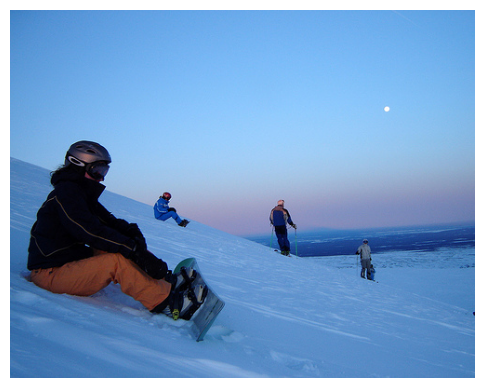

Captions de 113678030_87a6a6e42e.jpg
 • A snowboarder sits on a slope with skiers and boarders nearby .
 • A snowboarder takes a rest on the mountainside .
 • Snowboarders sitting in the snow while skiers take the hill .
 • The snowboarder is sitting down .
 • Two skiers stand , two sit on slopes .


In [3]:
random_img = random.choice(list(captions_dict.keys()))
show_image_all_captions(random_img, captions_dict, IMAGES_DIR)

Limpiamos los datos

In [4]:
cleaned_captions = {}

for img, caps in captions_dict.items():
    cleaned_captions[img] = [
        "<start> " + clean_caption(c) + " <end>"
        for c in caps
    ]

# ejemplo
list(cleaned_captions.items())[:1]

[('1000268201_693b08cb0e.jpg',
  ['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
   '<start> a girl going into a wooden building <end>',
   '<start> a little girl climbing into a wooden playhouse <end>',
   '<start> a little girl climbing the stairs to her playhouse <end>',
   '<start> a little girl in a pink dress going into a wooden cabin <end>'])]

In [5]:
print("Ejemplo sucio:", list(captions_dict.values())[0][0])
print("Ejemplo limpio:", list(cleaned_captions.values())[0][0])

Ejemplo sucio: A child in a pink dress is climbing up a set of stairs in an entry way .
Ejemplo limpio: <start> a child in a pink dress is climbing up a set of stairs in an entry way <end>


In [6]:
all_captions = []
for caps in cleaned_captions.values():
    all_captions.extend(caps)

len(all_captions)

40455

# 2. División de los datos

Obtenemos solo los NOMBRES de las imágenes para cada set


In [7]:
train_img_names, val_img_names, test_img_names = split_dataset(cleaned_captions)

Split realizado: Train=6472, Val=809, Test=810


Ahora aplanamos para el entrenamiento, para ello convertimos los nombres en listas gigantes de (imagen, texto)

In [8]:
# Train
train_img_paths, train_captions_text = flatten_dataset_data(
    train_img_names, 
    cleaned_captions  
)

# Val
val_img_paths, val_captions_text = flatten_dataset_data(
    val_img_names, 
    cleaned_captions  
)

# Test
test_img_paths, test_captions_text = flatten_dataset_data(
    test_img_names, 
    cleaned_captions  
)

In [9]:
# observar ejemplo
train_img_paths[:3], train_captions_text[:3]

(['2874984466_1aafec2c9f.jpg',
  '2874984466_1aafec2c9f.jpg',
  '2874984466_1aafec2c9f.jpg'],
 ['<start> a black and white dog is playing with a sheep in a field <end>',
  '<start> a dog and sheep run together <end>',
  '<start> a dog herds a sheep <end>'])

# 3. Creación del tokenizador y del vocabulario

In [10]:
# --- A. Calcular max_len ---
# Tomamos TODAS las captions (train, val, test) para encontrar la más larga
max_len = calc_max_length(all_captions)
print(f"Longitud máxima encontrada (max_len): {max_len}")

# --- B. Crear y Entrenar el Tokenizer ---
# Importante: Solo usar datos de TRAIN para crear el vocabulario (evitar data leakage)
# (Puedes limitar el vocabulario con num_words=5000 si quieres)
tokenizer = create_tokenizer(train_captions_text)
tokenizer.fit_on_texts(train_captions_text)

# Añadimos el token de padding al índice 0 (Keras lo hace por defecto, pero es bueno saberlo)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = len(tokenizer.word_index) + 1
print(f"Tamaño del vocabulario: {vocab_size}")

# --- C. Convertir Texto a Secuencias (seqs) y Padding ---
# Generamos las variables que te faltaban
seqs_train = text_to_padded_sequences(train_captions_text, tokenizer, max_len)
seqs_val = text_to_padded_sequences(val_captions_text, tokenizer, max_len)

print(f"Shape seqs_train: {seqs_train.shape}") # Debería ser (N_muestras_train, max_len)
print(f"Shape seqs_val: {seqs_val.shape}")

Longitud máxima encontrada (max_len): 39
Tamaño del vocabulario: 7715
Shape seqs_train: (32360, 39)
Shape seqs_val: (4045, 39)


In [11]:
dataset_train = create_tf_dataset(train_img_paths, seqs_train, IMAGES_DIR, max_len)
dataset_val = create_tf_dataset(val_img_paths, seqs_val, IMAGES_DIR, max_len)

In [12]:
print("--- Inspección de Estructura ---")
# .take(1) coge el primer batch (lote)
for images, captions in dataset_train.take(1):
    print(f"Shape del batch de imágenes: {images.shape}") 
    print(f"Shape del batch de captions: {captions.shape}")
    
    print(f"\nTipo de dato imágenes: {images.dtype}")
    print(f"Tipo de dato captions: {captions.dtype}")
    
    print("\nEjemplo de una secuencia de caption (números):")
    print(captions[0].numpy())

--- Inspección de Estructura ---
Shape del batch de imágenes: (64, 224, 224, 3)
Shape del batch de captions: (64, 39)

Tipo de dato imágenes: <dtype: 'float32'>
Tipo de dato captions: <dtype: 'int32'>

Ejemplo de una secuencia de caption (números):
[  3  28  10 252  34  57   4   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


2025-11-19 18:53:14.300008: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 5. Entrenamiento CNN + LSTM

In [13]:
# 1. Importar Modelos y Utils
from models.encoder import Encoder
from models.decoder_lstm import RNN_Decoder
import time
import tensorflow as tf
from utils.train import Trainer, get_optimizer # Importar la clase
from tqdm.notebook import tqdm # Importamos la versión bonita para notebooks

embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
BATCH_SIZE = 64 # Debe coincidir con lo que usaste en create_tf_dataset

encoder = Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = get_optimizer()
trainer = Trainer(encoder, decoder, optimizer)

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Obtenemos el ID de <start> una sola vez (es más eficiente pasar un int que todo el objeto tokenizer)
start_token_id = tokenizer.word_index['<start>']

EPOCHS = 5
print(f"Comenzando entrenamiento con Start Token ID: {start_token_id}")

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    # 1. Envolvemos el dataset con tqdm
    # Esto crea la barra de progreso automática
    with tqdm(dataset_train, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{EPOCHS}")
        
        for img_tensor, target in tepoch:
            # 2. Paso de entrenamiento
            batch_loss = trainer.train_step(
                img_tensor, 
                target, 
                start_token_id
            )
            
            total_loss += batch_loss
            
            # 3. Actualizamos la barra con el loss actual (visual, sin imprimir línea nueva)
            # Esto es genial porque ves si el loss baja en tiempo real sin ensuciar la pantalla
            tepoch.set_postfix(batch_loss=batch_loss.numpy())

    # 4. AL FINAL DEL EPOCH: Calculamos media e imprimimos UNA sola vez
    epoch_avg_loss = total_loss / len(dataset_train)
    
    print(f'Epoch {epoch + 1} FINAL Loss: {epoch_avg_loss:.4f}')
    print(f'Time taken: {time.time() - start:.2f} sec')
    
    # Guardar checkpoint cada 5 épocas
    if (epoch + 1) % 5 == 0:
        ckpt_manager.save()
        print(f"Checkpoint guardado en: {checkpoint_path}\n")
    else:
        print("\n") # Solo un salto de línea para separar

Comenzando entrenamiento con Start Token ID: 3


  0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 1 FINAL Loss: 1.5828
Time taken: 1673.59 sec




2025-11-19 19:21:08.446258: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 2 FINAL Loss: 1.2791
Time taken: 1724.35 sec




  0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 3 FINAL Loss: 1.1476
Time taken: 1696.43 sec




2025-11-19 20:18:09.192992: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 4 FINAL Loss: 1.0770
Time taken: 1704.61 sec




  0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 5 FINAL Loss: 1.0269
Time taken: 1681.50 sec
Checkpoint guardado en: ./checkpoints/train



In [15]:
print("--- Iniciando Fase 2: Fine-Tuning ---")

# 1. DESCONGELAR EL ENCODER
# Opción A: Descongelar TODO (Más arriesgado, requiere mucha memoria)
# encoder.resnet.trainable = True 

# Opción B: Descongelar solo las últimas capas (RECOMENDADA)
# Esto mantiene las características básicas (bordes, formas) congeladas y solo
# entrena la interpretación de alto nivel.

# Congelamos todas las capas excepto los últimos dos bloques
for layer in encoder.resnet.layers:
    layer.trainable = False

for layer in encoder.resnet.layers:
    if layer.name.startswith('conv4') or layer.name.startswith('conv5'):
        layer.trainable = True

# Verificar cuántas variables se entrenarán ahora
print(f"Variables entrenables del encoder: {len(encoder.trainable_variables)}")


# 2. BAJAR EL LEARNING RATE
# Es crucial reducirlo drásticamente (ej. dividir por 10 o 20)
optimizer.learning_rate.assign(1e-5)
print(f"Nuevo Learning Rate: {optimizer.learning_rate.numpy()}")


# 3. REANUDAR ENTRENAMIENTO (Pocas épocas)
# El Fine-tuning suele converger rápido. 5 o 10 épocas suelen bastar.
FINE_TUNE_EPOCHS = 5

for epoch in range(FINE_TUNE_EPOCHS):
    start = time.time()
    total_loss = 0
    
    # Usamos el mismo trainer, él detectará automáticamente 
    # que ahora encoder.trainable_variables tiene más cosas.
    with tqdm(dataset_train, unit="batch") as tepoch:
        tepoch.set_description(f"Fine-Tuning Epoch {epoch + 1}/{FINE_TUNE_EPOCHS}")
        
        for img_tensor, target in tepoch:
            batch_loss = trainer.train_step(img_tensor, target, start_token_id)
            total_loss += batch_loss
            tepoch.set_postfix(loss=batch_loss.numpy())

    print(f'FT Epoch {epoch + 1} Loss: {total_loss/len(dataset_train):.4f}')
    
    # Guardar checkpoints específicos de Fine-Tuning
    ckpt_manager.save()

--- Iniciando Fase 2: Fine-Tuning ---
Variables entrenables del encoder: 118
Nuevo Learning Rate: 9.999999747378752e-06


  0%|          | 0/506 [00:00<?, ?batch/s]

FT Epoch 1 Loss: 0.9861


  0%|          | 0/506 [00:00<?, ?batch/s]

FT Epoch 2 Loss: 0.9791


2025-11-19 22:10:52.187596: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/506 [00:00<?, ?batch/s]

FT Epoch 3 Loss: 0.9739


  0%|          | 0/506 [00:00<?, ?batch/s]

FT Epoch 4 Loss: 0.9691


  0%|          | 0/506 [00:00<?, ?batch/s]

FT Epoch 5 Loss: 0.9648


# 7. Evaluación

Imagen: /Users/hugogomez/Desktop/CDIA IV/PCD/flickr8k/images/408233586_f2c1be3ce1.jpg
Caption Real (aprox): <start> a dog playing with a ball in water <end>

--- PREDICCIÓN DEL MODELO ---
Caption Generado: a dog is playing in the water


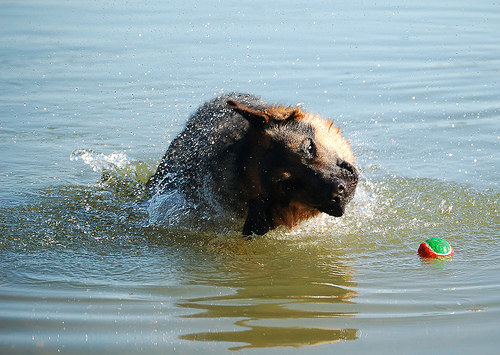

In [25]:
# 1. Importar las funciones
from utils.eval import evaluate, calculate_bleu_score
import random

# 1. Obtener nombre de archivo aleatorio
rid = random.randint(0, len(test_img_paths) - 1)
img_filename = test_img_paths[rid]  # Esto es solo "foto.jpg"

# 2. CONSTRUIR LA RUTA COMPLETA
# ¡Esta es la línea clave que te falta!
full_image_path = os.path.join(IMAGES_DIR, img_filename)

# 3. Generar Caption pasando la ruta completa
real_caption = test_captions_text[rid] # Esto es solo para comparar visualmente
print(f"Imagen: {full_image_path}")
print(f"Caption Real (aprox): {real_caption}")

result, attention_plot = evaluate(
    full_image_path, 
    encoder, 
    decoder, 
    tokenizer, 
    max_len
)

# 4. Mostrar resultado
print("\n--- PREDICCIÓN DEL MODELO ---")
predicted_sentence = ' '.join(result)
print(f"Caption Generado: {predicted_sentence}")

# Mostrar la imagen original para referencia rápida
from PIL import Image
Image.open(full_image_path)

In [27]:
test_full_paths = [os.path.join(IMAGES_DIR, name) for name in test_img_paths]
bleu_scores = calculate_bleu_score(
    encoder, 
    decoder, 
    tokenizer, 
    max_len, 
    test_full_paths,   # Tu lista completa de rutas de test
    cleaned_captions  # El diccionario maestro con los textos reales
)

# La función ya imprime los resultados, pero si quieres guardarlos:
b1, b2, b3, b4 = bleu_scores

Calculando BLEU para 4050 imágenes...


  0%|          | 0/4050 [00:00<?, ?it/s]


--- Resultados BLEU ---
BLEU-1: 0.3835
BLEU-2: 0.2609
BLEU-3: 0.1670
BLEU-4: 0.0990


In [8]:
import tensorflow as tf
import os
from models.encoder import Encoder
from models.decoder_lstm import RNN_Decoder
from utils.beam_search import beam_search_evaluate
from data.dataset import load_captions_csv, split_dataset, flatten_dataset_data, clean_caption
from data.vocab import create_tokenizer

# 1. CONFIGURACIÓN (Idéntica a tu entrenamiento)
embedding_dim = 256
units = 512
max_len = 39 # Ajusta esto si calculaste otro valor en el training (ej. 35, 40...)

print("⚠️ Reconstruyendo Tokenizer y recuperando Test Set...")

# 1. Cargar y limpiar (IGUAL que en el training)
CAPTIONS_PATH = "/Users/hugogomez/Desktop/CDIA IV/PCD/flickr8k/captions.txt"
captions_dict = load_captions_csv(CAPTIONS_PATH)

cleaned_captions = {}
for img, caps in captions_dict.items():
    cleaned_captions[img] = [f"<start> {clean_caption(c)} <end>" for c in caps]

# 2. Dividir (IGUAL que en training, misma seed=42 es vital)
# AQUÍ ESTÁ EL CAMBIO: Recuperamos train, val y test
train_img_names, val_img_names, test_img_names = split_dataset(cleaned_captions, seed=42)

print(f"✅ Datos divididos. Test set tiene {len(test_img_names)} imágenes.")

# 3. Aplanar datos de train (Solo para crear el tokenizer)
_, train_captions_text = flatten_dataset_data(train_img_names, cleaned_captions)

# 4. Crear Tokenizer
tokenizer = create_tokenizer(train_captions_text)
vocab_size = len(tokenizer.word_index) + 1
print(f"✅ Tokenizer reconstruido. Vocabulario: {vocab_size}")

# 5. INSTANCIAR MODELOS VACÍOS
encoder = Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, 7715)

# 6. PREPARAR CHECKPOINTS Y RESTAURAR
checkpoint_path = "/Users/hugogomez/Desktop/CDIA IV/PCD/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    status = ckpt.restore(ckpt_manager.latest_checkpoint)
    status.expect_partial()
    print(f"✅ Modelo restaurado desde: {ckpt_manager.latest_checkpoint}")
else:
    print("❌ No se encontró ningún checkpoint en esa carpeta.")

# ---------------------------------------------------------
# AHORA YA TIENES LA LISTA 'test_img_names' DISPONIBLE
# ---------------------------------------------------------
# Ejemplo: ver los primeros 5 nombres del test set
print("\nEjemplo de imágenes de test:", test_img_names[:5])

⚠️ Reconstruyendo Tokenizer y recuperando Test Set...
Split realizado: Train=6472, Val=809, Test=810
✅ Datos divididos. Test set tiene 810 imágenes.
✅ Tokenizer reconstruido. Vocabulario: 7714
✅ Modelo restaurado desde: /Users/hugogomez/Desktop/CDIA IV/PCD/checkpoints/train/ckpt-6

Ejemplo de imágenes de test: ['3153067758_53f003b1df.jpg', '3449170348_34dac4a380.jpg', '3626964430_cb5c7e5acc.jpg', '2286823363_7d554ea740.jpg', '241347204_007d83e252.jpg']


Probando imagen: /Users/hugogomez/Desktop/CDIA IV/PCD/flickr8k/images/2518094853_dfce24ce8c.jpg
Predicción: a red field


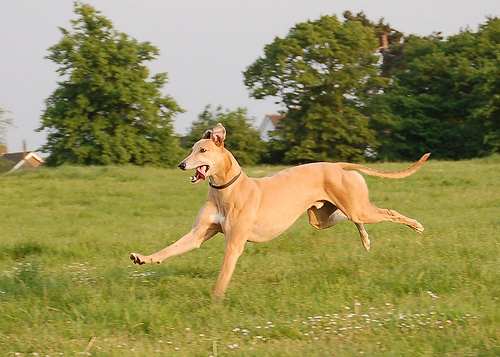

In [27]:
import os
import random
from PIL import Image
from IPython.display import display # Importante para mostrar imágenes en notebooks

IMAGES_DIR = "/Users/hugogomez/Desktop/CDIA IV/PCD/flickr8k/images" 

# Crear lista de rutas completas
test_full_paths = [os.path.join(IMAGES_DIR, name) for name in test_img_names]

# 1. Elegir UNA imagen al azar
img_path = random.choice(test_full_paths)
print(f"Probando imagen: {img_path}")

# 2. Generar predicción
# Asegúrate de pasar el vocab_size correcto si usaste el truco del 7715
caption = beam_search_evaluate(img_path, encoder, decoder, tokenizer, max_len, beam_width=5)
print("Predicción:", ' '.join(caption))

# 3. Mostrar la imagen
# ¡OJO! Aquí usamos 'img_path' (la foto elegida), no 'test_full_paths' (la lista entera)
display(Image.open(img_path))